<a href="https://colab.research.google.com/github/Shayankr/PyTorch_Basic_2_Advance/blob/master/PyTorch_CNN_02_05_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>CNN Implementation of Model</center>

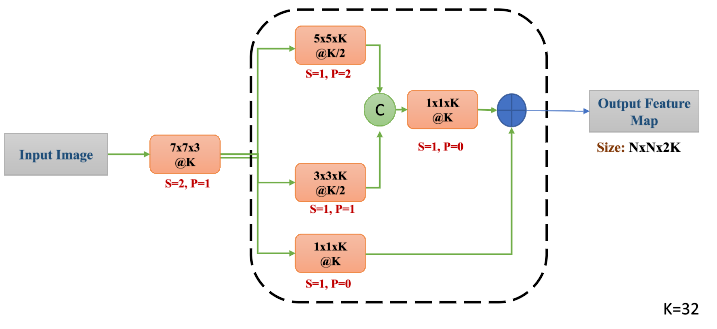

`GitHub link`: https://github.com/Shayankr/PyTorch_Basic_2_Advance/blob/master/PyTorch_CNN_02_05_2023.ipynb

I am Considering **CIFAR10 dataset** for the above described model:

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import Image

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(f"Using {device} device")

Using cuda device


In [ ]:
!nvidia-smi

Tue May  2 14:42:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )
# transform = transforms.Compose([transforms.Resize((227,227)),transforms.ToTensor(),normalize])
transform = transforms.Compose([transforms.ToTensor(),normalize])

In [ ]:
!rm -r /content/data

rm: cannot remove '/content/data': No such file or directory


In [ ]:
data_train = datasets.CIFAR10(root = "./data/", transform=transform, train = True, download = True)

data_test = datasets.CIFAR10(root="./data/", transform = transform, train = False, download = True)

100%|██████████| 170498071/170498071 [00:03<00:00, 46215101.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [ ]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size = 64, shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size = 64, shuffle = True)

In [ ]:
print(len(data_train))
print(len(data_test))
print(len(data_loader_train))
print(len(data_loader_test))

50000
10000
782
157


In [ ]:
img, label = data_train[1]
print(img.shape)
print(label)

torch.Size([3, 32, 32])
9


In [ ]:
N=32
K=32
N*N*K

32768

In [ ]:
class MyNet(nn.Module):
    def __init__(self, K=32, num_classes=10):
        super(MyNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=K, kernel_size=7, stride=2, padding=1),
            nn.BatchNorm2d(K),
            nn.ReLU()
        )

        self.layer2_1 = nn.Sequential(
            nn.Conv2d(K, K//2, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(K//2),
            nn.ReLU()
        )

        self.layer2_2 = nn.Sequential(
            nn.Conv2d(K, K//2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(K//2),
            nn.ReLU()
        )

        self.layer2_3 = nn.Sequential(
            nn.Conv2d(K, K, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(K),
            nn.ReLU()
        )

        self.layer3_1 = nn.Sequential(
            nn.Conv2d(K, K, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(K),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(6272, 2048),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2048, 512),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out_1 = self.layer1(x)
        out_21 = self.layer2_1(out_1)
        out_22 = self.layer2_2(out_1)
        out_23 = self.layer2_3(out_1)

        out_2 = torch.cat((out_21, out_22), dim=1)
        out_3 = self.layer3_1(out_2)

        output_sum = torch.add(out_23, out_3)
        # print(output_sum.shape)
        
        output = output_sum.reshape(output_sum.size(0), -1)
        output = self.fc(output)
        output = self.fc1(output)
        output = self.fc2(output)
        
        return output

In [ ]:
14*14*32

6272

In [ ]:
model = MyNet(K=32, num_classes=10)

In [ ]:
from torchsummary import summary

model = MyNet(K=32, num_classes=10)
summary(model, (3, 32,32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]          12,816
       BatchNorm2d-5           [-1, 16, 14, 14]              32
              ReLU-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           4,624
       BatchNorm2d-8           [-1, 16, 14, 14]              32
              ReLU-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           1,056
      BatchNorm2d-11           [-1, 32, 14, 14]              64
             ReLU-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 32, 14, 14]           1,056
      BatchNorm2d-14           [-1, 32,

In [ ]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=acdd486f5ef4b44001523029bb713e66463fd5c86302ed8379605a1ac14c646b
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


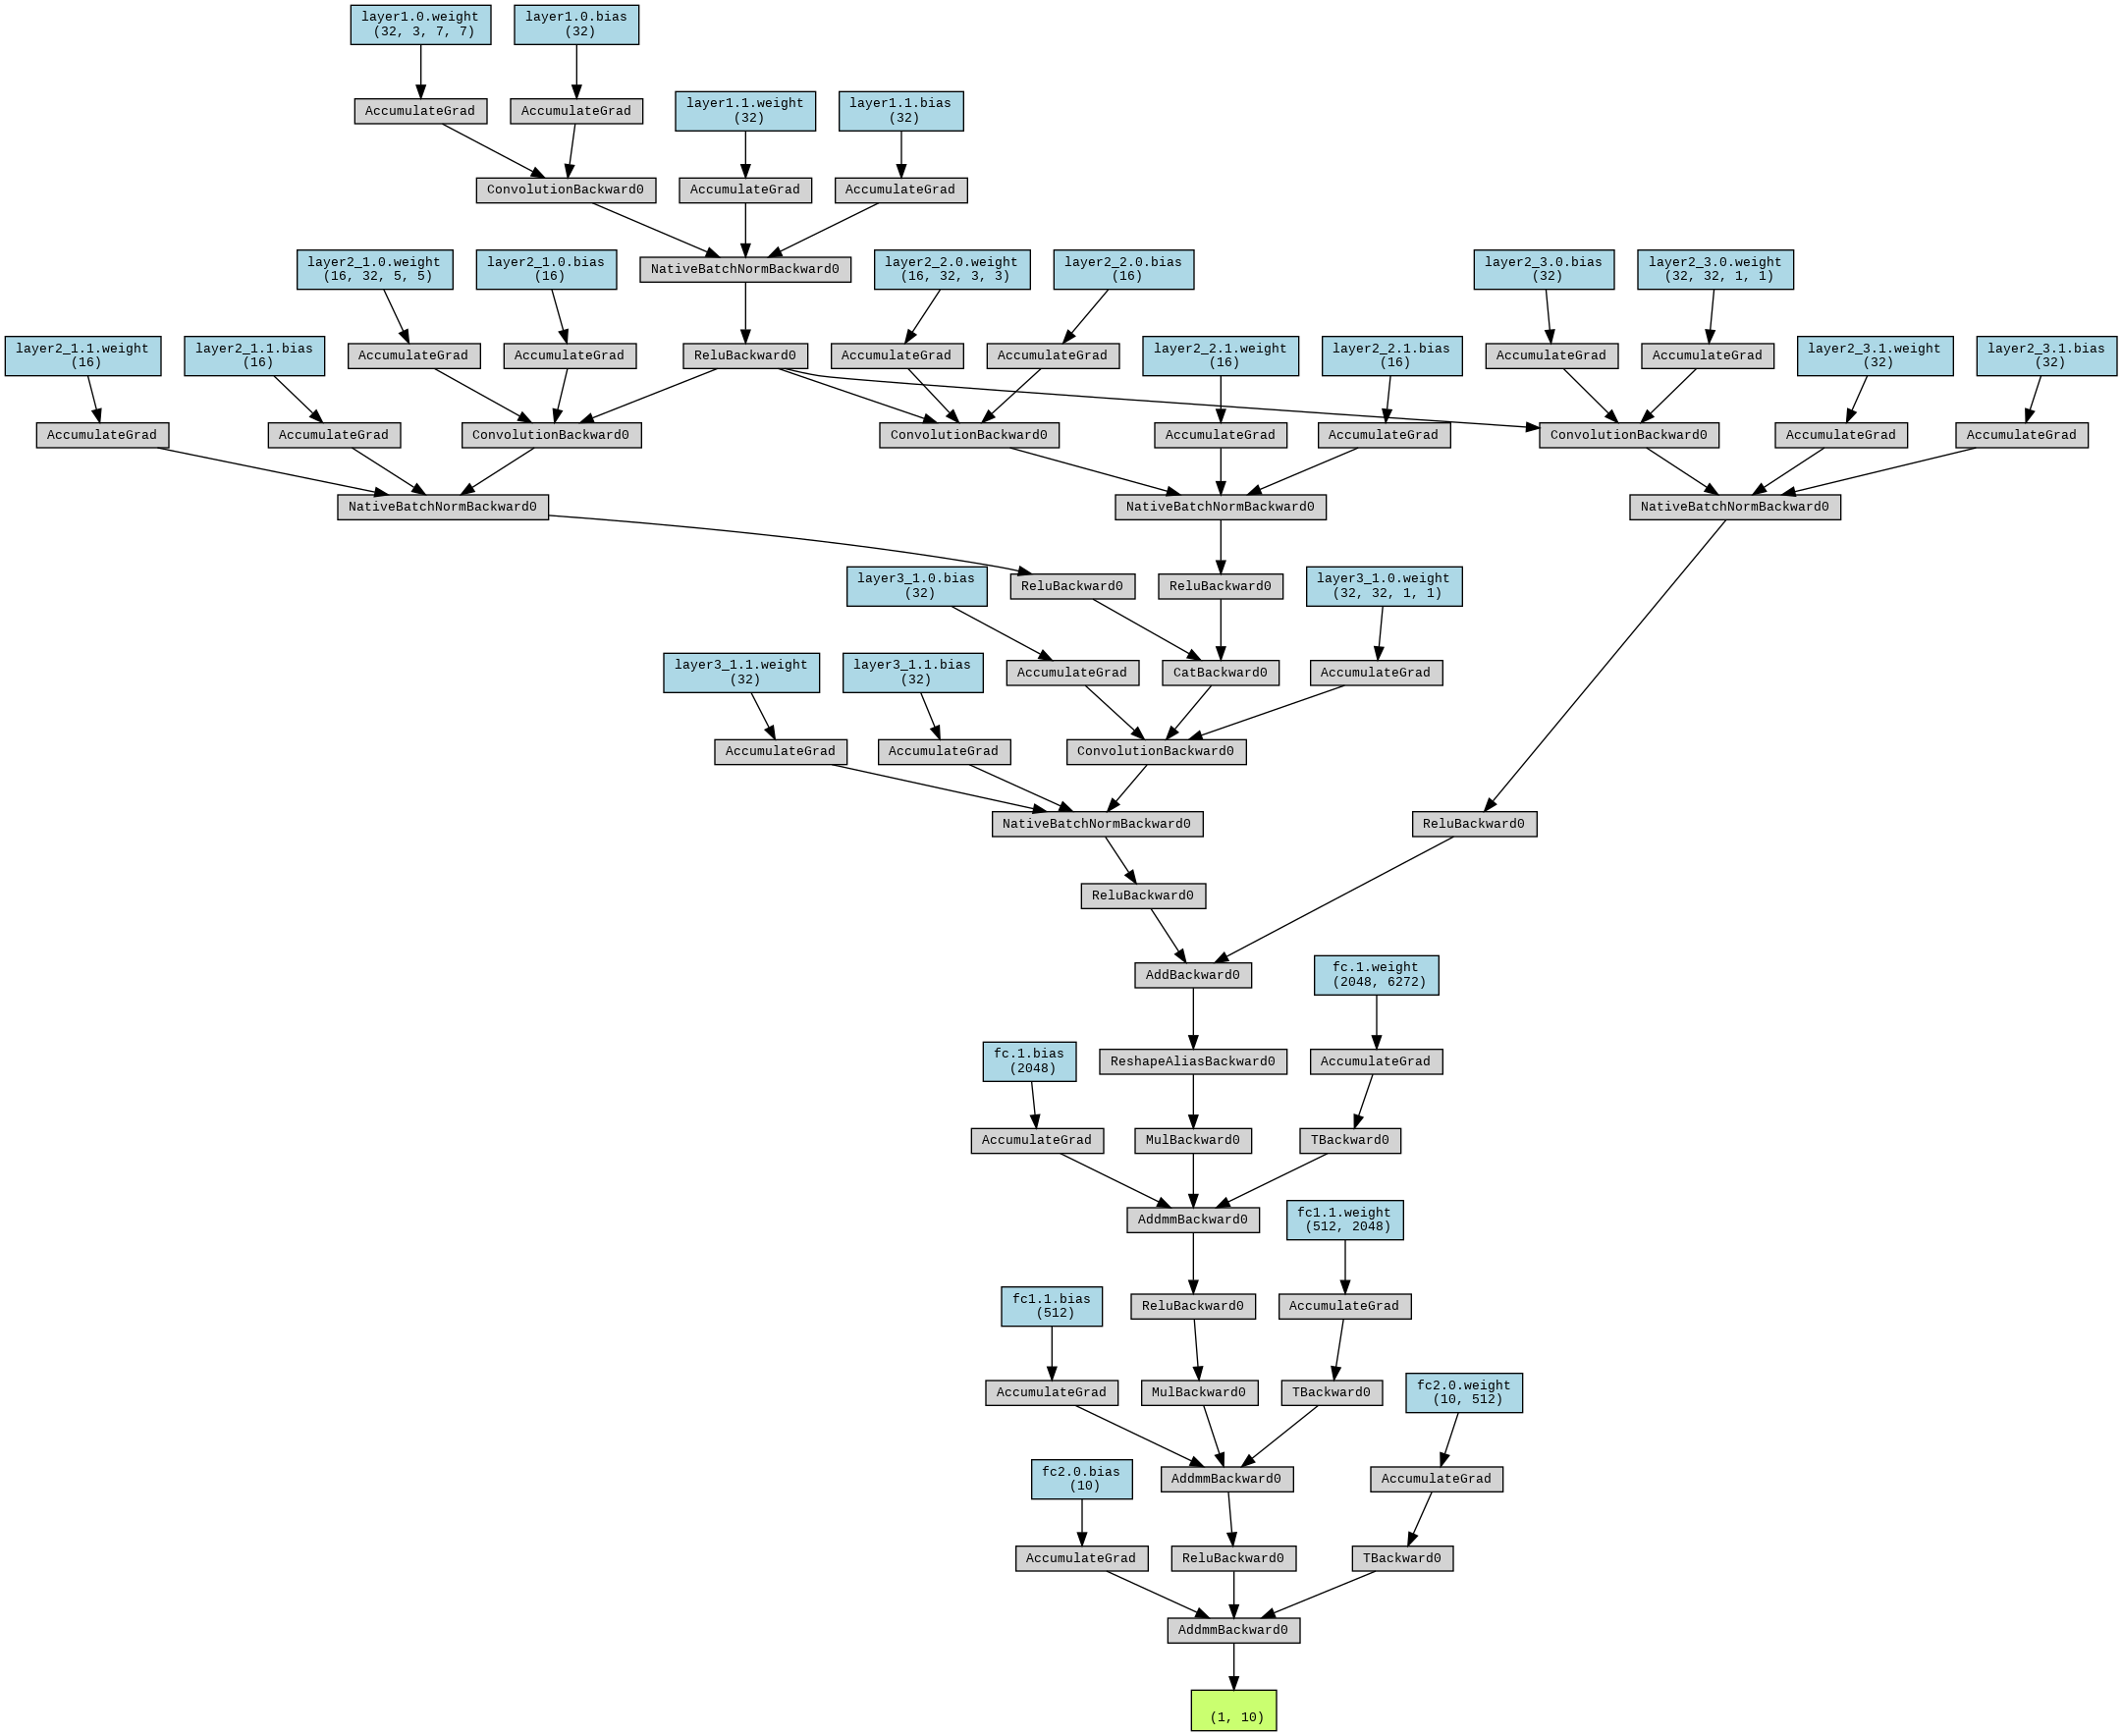

In [ ]:
from torchviz import make_dot
from IPython.display import Image
# # Create a random input tensor
x = torch.randn(1, 3, 32,32)

# Use make_dot to visualize the network graph
dot = make_dot(model(x), params=dict(model.named_parameters()))
# dot.render('alexnet', format='png')
dot.format = 'png'
dot.render('cifar10')

# Display the image in Jupyter Notebook
Image(filename='cifar10.png')

In [ ]:
print(f"model structure: {model}\n\n")

model structure: MyNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2_1): Sequential(
    (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2_2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3_1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
for name, param in model.named_parameters():
  print(f"Layer: {name} | size: {param.size()}\n")
  #break

Layer: layer1.0.weight | size: torch.Size([32, 3, 7, 7])

Layer: layer1.0.bias | size: torch.Size([32])

Layer: layer1.1.weight | size: torch.Size([32])

Layer: layer1.1.bias | size: torch.Size([32])

Layer: layer2_1.0.weight | size: torch.Size([16, 32, 5, 5])

Layer: layer2_1.0.bias | size: torch.Size([16])

Layer: layer2_1.1.weight | size: torch.Size([16])

Layer: layer2_1.1.bias | size: torch.Size([16])

Layer: layer2_2.0.weight | size: torch.Size([16, 32, 3, 3])

Layer: layer2_2.0.bias | size: torch.Size([16])

Layer: layer2_2.1.weight | size: torch.Size([16])

Layer: layer2_2.1.bias | size: torch.Size([16])

Layer: layer2_3.0.weight | size: torch.Size([32, 32, 1, 1])

Layer: layer2_3.0.bias | size: torch.Size([32])

Layer: layer2_3.1.weight | size: torch.Size([32])

Layer: layer2_3.1.bias | size: torch.Size([32])

Layer: layer3_1.0.weight | size: torch.Size([32, 32, 1, 1])

Layer: layer3_1.0.bias | size: torch.Size([32])

Layer: layer3_1.1.weight | size: torch.Size([32])

Layer: l

In [ ]:
del model

In [ ]:
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.005

model = MyNet(K=32, num_classes=10).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(data_loader_train) # define total_step to keep better track of steps when training

In [ ]:
from sklearn.metrics import f1_score

def compute_f1_score(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    score = f1_score(y_true, y_pred, average='macro')
    return score


## Training and Testing

In [ ]:
total_step = len(data_loader_train)
Train_Accuracy = []
Test_Accuracy = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    cnt = 0

    # start by iterating through the number of epochs, and then the batches in our training data:
    for i, (images, labels) in enumerate(data_loader_train):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        cnt += 1
        running_loss = running_loss + loss.data
        running_correct += (pred == labels).sum().item()
        loss.backward()
        optimizer.step()
        
    # Compute F1-score after every 5 epochs
    if epoch % 5 == 4:
        train_f1_score = compute_f1_score(model, data_loader_train)
        test_f1_score = compute_f1_score(model, data_loader_test)
        print("Epoch [{}/{}], Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%, Train F1-score: {:.4f}, Test F1-score: {:.4f}"
              .format(epoch+1, num_epochs, 100*running_correct/len(data_train), 100*testing_correct/len(data_test), train_f1_score, test_f1_score))

    # Evaluate model on test set
    testing_correct = 0
    with torch.no_grad():
        for images, labels in data_loader_test:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            testing_correct += (predicted == labels).sum().item()

    # Compute and print training and testing accuracy
    print("Epoch [{}/{}], Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%"
          .format(epoch+1, num_epochs, 100*running_correct/len(data_train), 100*testing_correct/len(data_test)))

    Train_Accuracy.append(running_correct/len(data_train))
    Test_Accuracy.append(testing_correct/len(data_test))

# torch.save(model.state_dict(), "/content/model_parameter.pth")


Epoch [1/10], Train Accuracy: 44.57%, Test Accuracy: 51.45%
Epoch [2/10], Train Accuracy: 56.82%, Test Accuracy: 58.67%
Epoch [3/10], Train Accuracy: 63.02%, Test Accuracy: 64.59%
Epoch [4/10], Train Accuracy: 67.35%, Test Accuracy: 66.74%
Epoch [5/10], Train Accuracy: 70.16%, Test Accuracy: 66.74%, Train F1-score: 0.7405, Test F1-score: 0.6920
Epoch [5/10], Train Accuracy: 70.16%, Test Accuracy: 69.49%
Epoch [6/10], Train Accuracy: 73.42%, Test Accuracy: 69.97%
Epoch [7/10], Train Accuracy: 78.01%, Test Accuracy: 69.47%
Epoch [8/10], Train Accuracy: 82.22%, Test Accuracy: 71.05%
Epoch [9/10], Train Accuracy: 85.79%, Test Accuracy: 70.62%
Epoch [10/10], Train Accuracy: 89.22%, Test Accuracy: 70.62%, Train F1-score: 0.9083, Test F1-score: 0.6880
Epoch [10/10], Train Accuracy: 89.22%, Test Accuracy: 69.23%


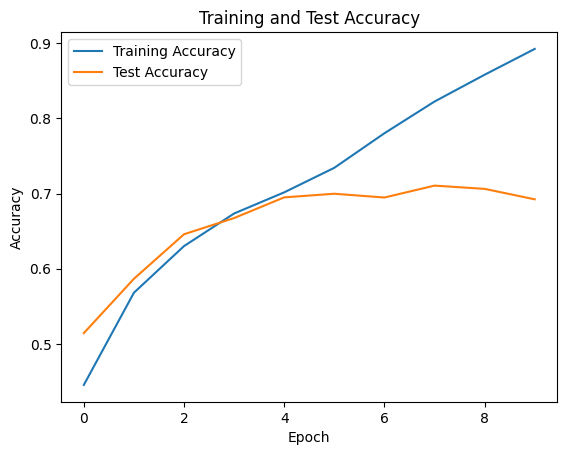

In [ ]:
plt.plot(range(num_epochs), Train_Accuracy, label='Training Accuracy')
plt.plot(range(num_epochs), Test_Accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

`After-5 epoch:`

    `Train F1-score: 0.7405, Test F1-score: 0.6920`

`After-10 epoch:`

    `Train F1-score: 0.9083, Test F1-score: 0.6880`

END

### I think my model gets overfitted, so, redesigning the model again:

In [ ]:
del model

In [ ]:
class MyNet(nn.Module):
    def __init__(self, K=32, num_classes=10):
        super(MyNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=K, kernel_size=7, stride=2, padding=1),
            nn.BatchNorm2d(K),
            nn.ReLU()
        )

        self.layer2_1 = nn.Sequential(
            nn.Conv2d(K, K//2, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(K//2),
            nn.ReLU()
        )

        self.layer2_2 = nn.Sequential(
            nn.Conv2d(K, K//2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(K//2),
            nn.ReLU()
        )

        self.layer2_3 = nn.Sequential(
            nn.Conv2d(K, K, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(K),
            nn.ReLU()
        )

        self.layer3_1 = nn.Sequential(
            nn.Conv2d(K, K, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(K),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(6272, 1024),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1024, 128),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out_1 = self.layer1(x)
        out_21 = self.layer2_1(out_1)
        out_22 = self.layer2_2(out_1)
        out_23 = self.layer2_3(out_1)

        out_2 = torch.cat((out_21, out_22), dim=1)
        out_3 = self.layer3_1(out_2)

        output_sum = torch.add(out_23, out_3)
        # print(output_sum.shape)
        
        output = output_sum.reshape(output_sum.size(0), -1)
        output = self.fc(output)
        output = self.fc1(output)
        output = self.fc2(output)
        
        return output

In [ ]:
model = MyNet(K=32, num_classes=10)
summary(model, (3, 32,32), device='cpu')
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]          12,816
       BatchNorm2d-5           [-1, 16, 14, 14]              32
              ReLU-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           4,624
       BatchNorm2d-8           [-1, 16, 14, 14]              32
              ReLU-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           1,056
      BatchNorm2d-11           [-1, 32, 14, 14]              64
             ReLU-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 32, 14, 14]           1,056
      BatchNorm2d-14           [-1, 32,

In [ ]:
num_classes = 10
num_epochs = 15
batch_size = 64
learning_rate = 0.005

model = MyNet(K=32, num_classes=10).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(data_loader_train) # define total_step to keep better track of steps when training

In [ ]:
total_step = len(data_loader_train)
Train_Accuracy = []
Test_Accuracy = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    cnt = 0

    # start by iterating through the number of epochs, and then the batches in our training data:
    for i, (images, labels) in enumerate(data_loader_train):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        cnt += 1
        running_loss = running_loss + loss.data
        running_correct += (pred == labels).sum().item()
        loss.backward()
        optimizer.step()
        
    # Compute F1-score after every 5 epochs
    if epoch % 5 == 4:
        train_f1_score = compute_f1_score(model, data_loader_train)
        test_f1_score = compute_f1_score(model, data_loader_test)
        print("Epoch [{}/{}], Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%, Train F1-score: {:.4f}, Test F1-score: {:.4f}"
              .format(epoch+1, num_epochs, 100*running_correct/len(data_train), 100*testing_correct/len(data_test), train_f1_score, test_f1_score))

    # Evaluate model on test set
    testing_correct = 0
    with torch.no_grad():
        for images, labels in data_loader_test:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            testing_correct += (predicted == labels).sum().item()

    # Compute and print training and testing accuracy
    print("Epoch [{}/{}], Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%"
          .format(epoch+1, num_epochs, 100*running_correct/len(data_train), 100*testing_correct/len(data_test)))

    Train_Accuracy.append(running_correct/len(data_train))
    Test_Accuracy.append(testing_correct/len(data_test))

# torch.save(model.state_dict(), "/content/model_parameter.pth")


Epoch [1/15], Train Accuracy: 41.15%, Test Accuracy: 48.05%
Epoch [2/15], Train Accuracy: 53.47%, Test Accuracy: 56.59%
Epoch [3/15], Train Accuracy: 59.62%, Test Accuracy: 61.08%
Epoch [4/15], Train Accuracy: 63.53%, Test Accuracy: 63.16%
Epoch [5/15], Train Accuracy: 66.26%, Test Accuracy: 63.16%, Train F1-score: 0.7300, Test F1-score: 0.6906
Epoch [5/15], Train Accuracy: 66.26%, Test Accuracy: 68.92%
Epoch [6/15], Train Accuracy: 70.95%, Test Accuracy: 70.52%
Epoch [7/15], Train Accuracy: 75.05%, Test Accuracy: 71.38%
Epoch [8/15], Train Accuracy: 78.59%, Test Accuracy: 70.64%
Epoch [9/15], Train Accuracy: 82.17%, Test Accuracy: 70.67%
Epoch [10/15], Train Accuracy: 84.99%, Test Accuracy: 70.67%, Train F1-score: 0.8736, Test F1-score: 0.6969
Epoch [10/15], Train Accuracy: 84.99%, Test Accuracy: 69.41%
Epoch [11/15], Train Accuracy: 88.09%, Test Accuracy: 68.82%
Epoch [12/15], Train Accuracy: 90.00%, Test Accuracy: 70.67%
Epoch [13/15], Train Accuracy: 91.47%, Test Accuracy: 69.51%
E

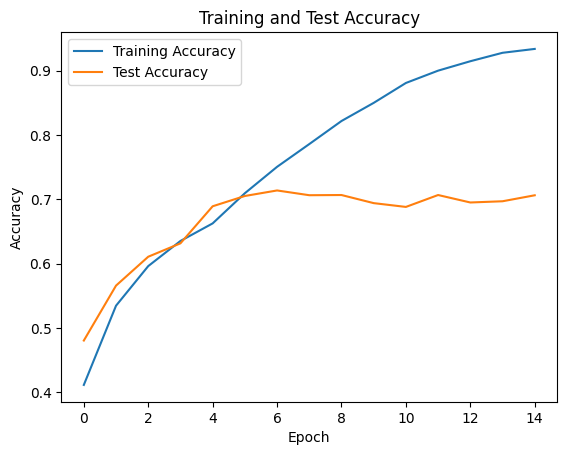

In [30]:
plt.plot(range(num_epochs), Train_Accuracy, label='Training Accuracy')
plt.plot(range(num_epochs), Test_Accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

**Coclude:** I saw that `Training Accuracy goes on increasing`, but `Testing Accuracy is around 69% to 71%` as shown from `5th epoch to 15th epoch`.

`After-5 epoch:`

    `Train F1-score: 0.7300, Test F1-score: 0.6906`

`After-10 epoch:`

    `Train F1-score: 0.8736, Test F1-score: 0.6969`

`After-15 epoch:`

    `Train F1-score: 0.9549, Test F1-score: 0.7062`

END

### ReDesign Model
**Since my Training Accuracy goes on increasing but Test Accuracy almost constant:**
I want to modify my Model to get either:
1. Testing Accuracy also increases, or
2. Training Accuracy also gets approxly constant, not varyig much as epoch increases.

In [39]:
# modify model further:
2+2

4

END